# Power Flow Basic Model: based on Newton-Raphson algorithm

### Usage

- Simulate the balanced line flows when giving reasonable electrical settings of power network parameters, including active and reactive power, voltage magnitude and amplitude. It doesn't ignore line losses to simulate precise balance.

- Check voltages and flows against limits for all probable situations, e.g. various generation and load scenarios.

- Produce dataset of lines flows in networks for power flow studies. In some applications such as resilience, only need the power supply and demand balancing results, no need to consider the cost - thus no need to apply optimization process for optimal power flows.

- Initialize other calculations (dynamics, faults).

### Model Input

1. buses: 
- name
- carrier (energy carrier: can be “AC” or “DC” for electrical buses, or “heat” or “gas” for links.)
- v_nom (kV, nominal voltage)
- optional: x (position (e.g. longitude)), y (position (e.g. latitude))
2. generators: 
- name
- bus (name of bus to which generator is attached)
- p (kW, nominal active power)
- optional: q (kVar, nominal reactive power)
3. loads: 
- name
- bus (name of bus to which load is attached)
- p = p_set (kW, active power consumption (positive if the load is consuming power))
- optional: q (kVar, reactive power consumption (positive if the load is consuming power))
4. lines: 
- name
- bus0 (name of first bus to which branch is attached)
- bus1 (name of second bus to which branch is attached)
- x (Siemens, series reactance)
- r (Siemens, series resistance)
4. links: 
- name
- bus0 (name of first bus to which link is attached)
- bus1 (name of second bus to which link is attached)
- p_set (kW, the dispatch set point for p0 of the link in PF) 
= p_0 (kW, active power at bus0 (positive if branch is withdrawing power from bus0)) 
= -p_1 (kW, active power at bus1 (positive if branch is withdrawing power from bus1))
- optional: q_set (kVar, the dispatch set point for q0 of the link in PF)

### Model Output

1. Power flows for lines in steady state: 
- lines-p0.csv: kW, active power at bus0 (positive if branch is withdrawing power from bus0)
- lines-p1.csv: kW, active power at bus1 (positive if branch is withdrawing power from bus1)
- lines-q0.csv: kW, reactive power at bus0 (positive if branch is withdrawing power from bus1)
- lines-q1.csv: kW, reactive power at bus1 (positive if branch is withdrawing power from bus1)
2. Active and reactive power for all buses in equilibrium: 
- buses-p.csv: kW, active power at bus (positive if net generation at bus, i.e. bus is withdrawing power from branch)
- buses-q.csv: kVar, reactive power (positive if net generation at bus, i.e. bus is withdrawing power from branch)
3. Complex voltage and Apparent power for all buses in the balanced power grid : 
- buses-v_mag.csv: kV, Voltage magnitude
- buses-v_ang.csv: rad, Voltage angle

### Model Method

The whole solving process of the nonlinear equation system using N-R method is elegant, by only solving specific parts of the equation system. Here are key steps:
1. Use the collected information to construct the node admittance matrix and the line impedance matrix.
2. Construct the power injection vectors, containing information on voltage, active and reactive power injections at each bus.
3. Set initial guesses for voltage phase and magnitude.
4. Perform Newton-Raphson algorithm to solve inplicit part of the nonlinear equation system in power flow nodal analysis.
5. Using the explicit equations, calculate the active injection at the slack bus and the reactive injections at the PV buses.
6. Calculate line flows.

If want to learn more, please refer to [text slides](Materials\TextSlides-Load%20generation%20balance.pptx)

# Calculation Example:

### Source of Original Data:
https://github.com/PyPSA/PyPSA/tree/master/examples/ac-dc-meshed/ac-dc-data/results-lpf

Downloaded the 9-node power network data from the [PyPSA example](Original_data\Data_lpf_result), selected the necessary parts as the [model input](Model_input), and then used this model to simulate and calculate to obtain the [model output data](Model_output). Moreover, after comparing with the original data, our results are very close to it, so it can be judged that the function of this model is correct.

A comparison between PyPSA and this model: this model uses a nonlinear set of equations to accurately calculate the power flow and the electrical state of each bus in the power grid. After being simplified, this model is actually included in the optimization model of pypsa as one of the most important optimization constraints.

## Model Input: 

### 1. Read input data

We will use an example network dataset to verify this model. Let's input and review the [data](Model_input). 

**You can also modify the following code to input the data you want to simulate.**

To gather the topology of the grid:  
- buses.csv,   
- lines.csv,  
- links.csv,  
- loads.csv,   
- generators.csv.

To collect data on power injections at each bus for each snapshot:
- generators-p.csv, 
- links-p_set.csv,  
- loads-p_set.csv,  
- snapshots.csv.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import csr_matrix
import sympy as sp
import logging

logging.info("Script started...")

## Input
buses_df = pd.read_csv("./Model_input/buses.csv")
generators_df = pd.read_csv("./Model_input/generators.csv")
lines_df = pd.read_csv("./Model_input/lines.csv")
links_df = pd.read_csv("./Model_input/links.csv")
loads_df = pd.read_csv("./Model_input/loads.csv")
generators_p_df = pd.read_csv("./Model_input/generators-p.csv")
links_p0_df = pd.read_csv("./Model_input/links-p_set.csv")
loads_p_df = pd.read_csv("./Model_input/loads-p_set.csv")
snapshots_df = pd.read_csv("./Model_input/snapshots.csv")

# add ids for nodes
buses_df["id"] =  range(len(buses_df))

# create a mapping of node names to ids
name_to_id = buses_df.set_index("name")["id"].to_dict()
id_to_name = {value: key for key, value in name_to_id.items()}

### 2. Build grid graph

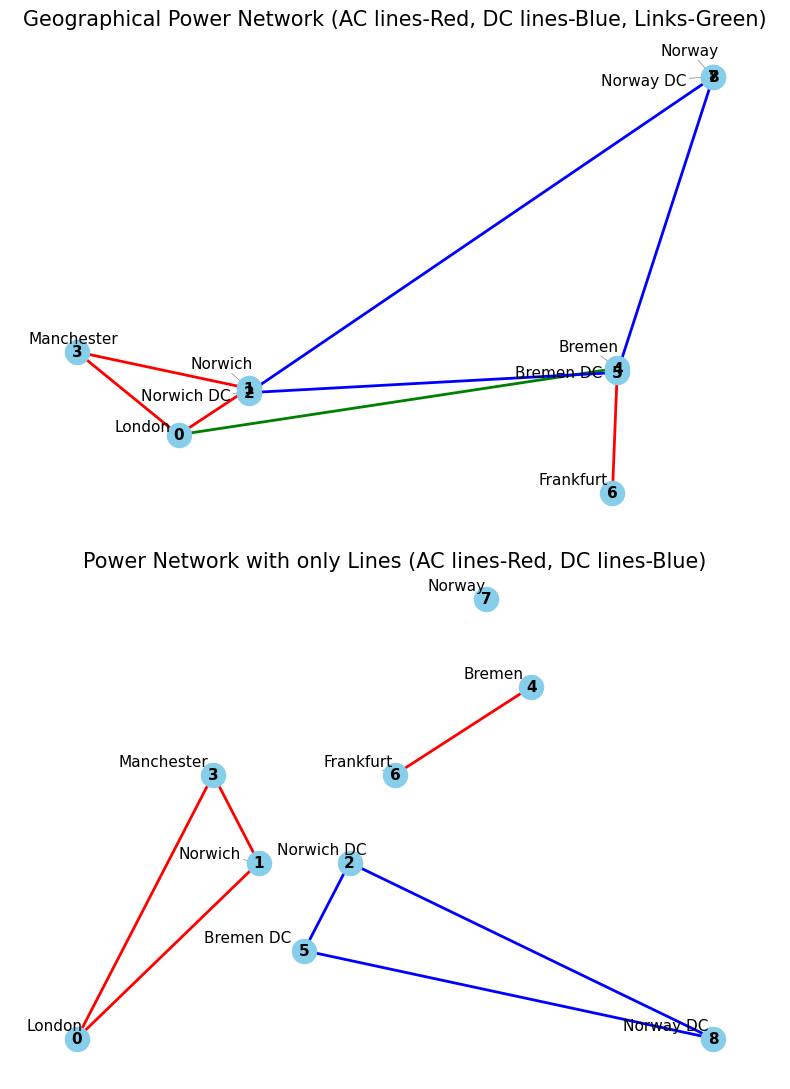

In [2]:
# create a new empty undirected graph with only lines
G_lines = nx.Graph()

# add nodes from buses
for _, row in buses_df.iterrows():
    # iterate over DataFrame rows as (index, Series) pairs
    G_lines.add_node(row["id"], name=row['name'], latitude=row['y'], longitude=row['x'], carrier=row['carrier'], vnom=row['v_nom'])

# add edges and attribution: lines, links
for _, row in lines_df.iterrows():
    from_node = name_to_id[row['bus0']]
    to_node = name_to_id[row['bus1']]
    impedance = row["r"] + 1j * row["x"]
    G_lines.add_edge(from_node, to_node, impedance=impedance)

# create another new empty undirected graph with all edges
power_network = G_lines.copy()

for _,row in links_df.iterrows():
    from_node = name_to_id[row['bus0']]
    to_node = name_to_id[row['bus1']]
    power_network.add_edge(from_node, to_node, efficiency=1)
    # set the efficiency = 1 to build lossless links

# plot the graphs
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 11))

# first network
# read the location information of nodes
pos = {node: (data["longitude"], data['latitude']) for node, data in power_network.nodes(data=True)}
# set the edge color
edge_colors = []
for bus0, bus1, data in power_network.edges(data=True):
    if "efficiency" in data.keys():
        edge_colors.append("green") # links (eg. HVDC, converters...) are green
    elif power_network.nodes[bus0]["carrier"] == "DC":
        edge_colors.append("blue") # DC lines are blue
    elif power_network.nodes[bus0]["carrier"] == "AC":
        edge_colors.append("red") # AC lines are red

# Plot the first graph on ax1
nx.draw(power_network, pos, ax=ax1, with_labels=True, node_size=300, node_color='skyblue', 
        font_size=11, font_weight='bold', edge_color=edge_colors, width=2)

# Plot the node labels for the first graph
node_labels = nx.get_node_attributes(power_network, 'name')
texts = []
for node, (x, y) in pos.items():
    text = ax1.text(x, y, node_labels[node], fontsize=11, ha='right', va='bottom')
    texts.append(text)

# Adjust label position to avoid overlap
from adjustText import adjust_text
adjust_text(texts, ax=ax1, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Set labels and title for the first graph
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Geographical Power Network (AC lines-Red, DC lines-Blue, Links-Green)', fontsize=15)

# second graph
if nx.check_planarity(G_lines)[0]:  # Check if the graph is planar
    pos2 = nx.planar_layout(G_lines)
# set the edge color
edge_colors2 = []
for bus0, bus1, data in G_lines.edges(data=True):
    if "efficiency" in data.keys():
        edge_colors2.append("green") # links (eg. HVDC, converters...) are green
    elif power_network.nodes[bus0]["carrier"] == "DC":
        edge_colors2.append("blue") # DC lines are blue
    elif power_network.nodes[bus0]["carrier"] == "AC":
        edge_colors2.append("red") # AC lines are red
nx.draw(G_lines, pos=pos2, ax=ax2, with_labels=True, node_size=300, node_color='skyblue', 
        font_size=11, font_weight='bold', width=2, edge_color=edge_colors2,)
# Plot the node labels for the first graph
node_labels2 = nx.get_node_attributes(G_lines, 'name')
texts2 = []
for node, (x, y) in pos2.items():
    text = ax2.text(x, y, node_labels2[node], fontsize=11, ha='right', va='bottom')
    texts2.append(text)
adjust_text(texts2, ax=ax2, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
ax2.set_title('Power Network with only Lines (AC lines-Red, DC lines-Blue)', fontsize=15)

# Show the plots
plt.tight_layout()
plt.savefig('./Model_output/PowerNetwork_image.png', dpi=300) 
plt.show()

## Model Method:

### 1. Build equations of passive branches: lines - admittance matrix

#### 1.1 Distinguish between "Lines" and "Links"

We calculate the admittance of each lines in order to build the admittance matrix following the rule of its structure.
But here, we have “links” that are different from (AC and DC) “lines”.
Links don't have specific impedance/admittance, but can have an efficiency loss and a marginal cost. The flows in links are fully controllable. Networks of links implement Kirchoff’s Current Law (energy conservation at each bus), but not Kirchoff’s Voltage Law, which is obeyed by networks of passive branches.

Links can be used for any element with a controllable power flow: such as a bidirectional point-to-point HVDC link, a unidirectional lossy HVDC link, a converter between an AC and a DC network, a heat pump or resistive heater from an AC/DC bus to a heat bus. 

In our example, we assume the efficiency of links as default: 1, that is "lossless". Its default settings allow only for power flow in one direction, from bus 0 to bus 1. And active power at bus 0 is positive if branch is withdrawing power from bus 0.

In [4]:
links_df

,name,bus0,bus1,capital_cost,p_max_pu,p_min_pu,p_nom,p_nom_extendable
0,Norwich Converter,Norwich,Norwich DC,0.210000,0.9,-0.9,1000.0,True
1,Norway Converter,Norway,Norway DC,0.200000,0.9,-0.9,1000.0,True
2,Bremen Converter,Bremen,Bremen DC,0.190000,0.9,-0.9,1000.0,True
3,DC link,London,Bremen,0.876534,0.9,-0.9,1000.0,True


In [5]:
lines_df

,name,bus0,bus1,capital_cost,r,s_nom,s_nom_extendable,x,v_nom
0,0,London,Manchester,0.136716,0.000000,40000.0,True,0.796878,380.0
1,1,Manchester,Norwich,0.133492,0.000000,40000.0,True,0.391560,380.0
2,2,Bremen DC,Norwich DC,0.008673,0.212604,40000.0,True,0.000000,200.0
3,3,Norwich DC,Norway DC,0.129126,0.486164,40000.0,True,0.000000,200.0
4,4,Norway DC,Bremen DC,0.062430,0.428727,40000.0,True,0.000000,200.0
5,5,Norwich,London,0.021852,0.000000,40000.0,True,0.238800,380.0
6,6,Bremen,Frankfurt,0.200000,0.000000,40000.0,True,0.400000,380.0


#### 1.2 Calculate Admittance Matrix

We calculate the admittance of each lines in order to build the admittance matrix following the rule of its structure. We want the admittance matrix Y to be the same for all snapshots for convenience here.

Structure of the admittance matrix: (refer to slides: page 35-38)
- Rows and columns of Y correspond to nodes of the network 
- Diagonal element (𝑖,𝑖): Sum of the admittances connected to node 𝑖
- Off-diagonal element (𝑖,𝑗): Minus admittance between nodes 𝑖 and 𝑗

Given the network data, we can build the admittance matrix directly.

In [3]:
## Calculate Y matrix (Admittance Matrix) for all buses.
def creat_ymatrix(buses,lines):
    # Parameter: buses is a list of numbers
    n = len(buses)
    ymatrix = np.zeros((n,n),dtype=complex)

    # we already have a mapping of node names to ids: name_to_id

    for _, row in lines.iterrows():
        # read the DF by row
        from_idx =  name_to_id[row.bus0]
        to_idx = name_to_id[row.bus1]
        impedance = row["r"] + 1j * row["x"]  # impedance is always positive, Ohm
        # print("r",row["r"],"x", row["x"], impedance)
        admittance = 1 / impedance  # Siemens
        ymatrix[from_idx, to_idx] -= admittance
        ymatrix[to_idx,from_idx] -= admittance
        ymatrix[from_idx,from_idx] += admittance
        ymatrix[to_idx,to_idx] += admittance

    return ymatrix

ymatrix = creat_ymatrix(buses_df,lines_df)
# apart the imaginary and real part of the Y matrix
# Y matrix is symmetrical along the diagonal
# real part
G = np.real(ymatrix)
# imaginary part
B = np.imag(ymatrix)

# check if G, B is right
he = G + 1j*B
if np.array_equal(ymatrix, he):
    print("continue")

continue


### 2. Prepare for calculations

#### 2.1 Classify all buses to PV or PQ control

In [6]:
## Classify all buses to PV or PQ control
# generator buses are PVbus
PVbus = []
for index, row in generators_df.iterrows():
    node =  name_to_id[row["bus"]]
    if node not in PVbus:
        PVbus.append(node)
# buses with only loads are PQ buses
PQbus = []
for index, row in loads_df.iterrows():
    node =  name_to_id[row["bus"]]
    if node not in PVbus:
        if node not in PQbus:
            PQbus.append(node)
# classify other buses
for node in buses_df["id"]:
    if node not in PVbus and node not in PQbus:
    # Other buses without generators OR loads are otherbus, usually use for links: HVDC, inverters...
        if id_to_name[node] in links_df["bus1"].values:
            corresponding_bus0 = links_df.loc[links_df['bus1'] == id_to_name[node], 'bus0'].tolist()[0]
            corresponding_id = name_to_id[corresponding_bus0]
            if corresponding_id in PQbus:
                PQbus.append(node)
            else:
                #if is slack, also count as PV bus
                PVbus.append(node)    
All_buses = PVbus + PQbus

#### 2.2 Define outputs:

In [7]:
## Define outputs:
output_P = {}
output_Q = {}
output_V = {}
output_theta = {}
output_line_p0 = {}
output_line_p1 = {}
output_line_q0 = {}
output_line_q1 = {}
# Assistant dictionaries
all_V = {}
all_theta = {}
for time in snapshots_df["name"]:
    output_P[time] = {}
    output_Q[time] = {}
    output_V[time] = {}
    output_theta[time] = {}
    all_V[time] = {}
    all_theta[time] = {}

#### 2.3 Find the connected components after excluding links

In [8]:
## Find the connected components
connected_components = list(nx.connected_components(G_lines))

### 3. Function construction and related theoretical knowledge

#### 3.1 Theoretical knowledge

##### a. Nodal Power Balance Expression

The nodal power balance can be expressed as followed:
Active power injection at bus k: 
$$
P_k = \sum_{i=1}^{N} V_k V_i [G_{ki}cos(\theta_{ki})+B_{ki}sin{\theta_{ki}}]
$$
$$
P_k = P_k^G - P_k^L
$$
Reactive power injection at bus k: 
$$
Q_k = \sum_{i=1}^{N} V_k V_i [G_{ki}sin(\theta_{ki})-B_{ki}cos{\theta_{ki}}]
$$
$$
Q_k = Q_k^G - Q_k^L
$$
Only use P and Q of PQ buses and P of PV buses which is classified as implicit equations.

##### b. Implicit Equations

The equations with known P and Q are called implicit equations. Apply NR method to the nodal power balance equations (only the implicit part), where the unknown parameters are voltage magnitude $V$ and phase $\theta$ at node. We need to use data of PV buses and PQ buses.

By solving this implicit part of equation system using N-R method, we can calculate the value of unknown V and theta. 
Then use the rest explicit equations of equation system to calculate the rest unknown P and Q. 

In this way, all unknow parameters are solved. Once get the P, Q, V, theta of every bus in the power network, calculate the lines flows for futher applications.

##### c. Newton-Raphson method

Use the Newton-Raphson method or other iterative methods to solve the implicit part of power flow equations. Formulate the power flow equations as a set of nonlinear equations involving node voltages and power injections.

Steps of NR method:

1. Assume there are m implicit equations. It is easy to prove that the number of unknown parameters is equal to the number of equations, m.

    According Taylor first-order expansion at point $ (x_1^0, x_2^0,..., x_m^0) $, 
$$
f_i(x_1^0, x_2^0,..., x_m^0)+\sum_{j=1}^{m} \frac{\partial f}{\partial x_i} (x_i - x_i^0) = 0
$$
$$
i=1,2,...,m 
$$
    

2. Rewrite the partial differential part in matrix form, and get the Jacobian matrix $ (m \times m)$ : $ J(x_1^0, x_2^0,..., x_m^0) $ at point $ (x_1^0, x_2^0,..., x_m^0) $
$$ 
\begin{pmatrix} 
\frac {\partial f_1(x_1^0, x_2^0,..., x_m^0)}{\partial x_1} & \frac {\partial f_1(x_1^0, x_2^0,..., x_m^0)}{\partial x_2} & ... & \frac{\partial f_1(x_1^0, x_2^0,..., x_m^0)}{\partial x_m} \\ 
\frac {\partial f_2(x_1^0, x_2^0,..., x_m^0)}{\partial x_1} & \frac {\partial f_2(x_1^0, x_2^0,..., x_m^0)}{\partial x_2} & ... & \frac{\partial f_2(x_1^0, x_2^0,..., x_m^0)}{\partial x_m} \\
\vdots & \vdots & ... & \vdots\\ 
\frac {\partial f_m(x_1^0, x_2^0,..., x_m^0)}{\partial x_1} & \frac {\partial f_m(x_1^0, x_2^0,..., x_m^0)}{\partial x_2} & ... & \frac{\partial f_m(x_1^0, x_2^0,..., x_m^0)}{\partial x_m}
\end{pmatrix}
$$

3. The matrix form of system of the implicit equations is:
$$
J(x_1^0, x_2^0,..., x_m^0) \times \begin{pmatrix} x_1-x_1^0 \\ x_2-x_2^0 \\ \vdots \\ x_m-x_m^0 \end{pmatrix} = - \begin{pmatrix} f_1(x_1^0, x_2^0,..., x_m^0) \\ f_2(x_1^0, x_2^0,..., x_m^0) \\ \vdots \\ f_m(x_1^0, x_2^0,..., x_m^0) \end{pmatrix}
$$

4. Invert the Jacobian matrix
$$ J(x_1^0, x_2^0,..., x_m^0)^{-1} $$

5. Calculate the corrections $ \Delta x_i, i=1,2,...,m$
$$
\begin{pmatrix} \Delta x_1 \\ \Delta x_2 \\ \vdots \\ \Delta x_m \end{pmatrix} =- J(x_1^0, x_2^0,..., x_m^0)^{-1} \begin{pmatrix} f_1(x_1^0, x_2^0,..., x_m^0) \\ f_2(x_1^0, x_2^0,..., x_m^0) \\ \vdots \\ f_m(x_1^0, x_2^0,..., x_m^0) \end{pmatrix}
$$

6. Considering the iteration, the equations become:

$$
\begin{pmatrix} x_1^{k+1} \\ x_2^{k+1} \\ \vdots \\ x_m^{k+1} \end{pmatrix} - \begin{pmatrix} x_1^{k} \\ x_2^{k} \\ \vdots \\ x_m^{k} \end{pmatrix} 

= \begin{pmatrix} \Delta x_1^k \\ \Delta x_2^k \\ \vdots \\ \Delta x_m^k \end{pmatrix} 

= - J(x_1^k, x_2^k,..., x_m^k)^{-1} \begin{pmatrix} f_1(x_1^k, x_2^k,..., x_m^k) \\ f_2(x_1^k, x_2^k,..., x_m^k) \\ \vdots \\ f_m(x_1^k, x_2^k,..., x_m^k) \end{pmatrix}
$$

7.  Set convergence criteria, such as maximum iterations or error tolerance for $\Delta x^k$. Then $x^{k+1} = x^{k} + \Delta x^k$ is the solution of implicit equations:
$$
\begin{pmatrix} x_1^{k+1} \\ x_2^{k+1} \\ \vdots \\ x_m^{k+1} \end{pmatrix}
$$

##### d. Specific form of J matrix after substituting the nodal balance expression 

The Jacobian matrix $ (m \times m)$ : $ J(x_1^0, x_2^0,..., x_m^0) $ at point $ (x_1^k, x_2^k,..., x_m^k) $
$$ 
\begin{pmatrix} 
\frac {\partial f_1(x_1^k, x_2^k,..., x_m^k)}{\partial x_1} & \frac {\partial f_1(x_1^k, x_2^k,..., x_m^k)}{\partial x_2} & ... & \frac{\partial f_1(x_1^k, x_2^k,..., x_m^k)}{\partial x_m} \\ 
\frac {\partial f_2(x_1^k, x_2^k,..., x_m^k)}{\partial x_1} & \frac {\partial f_2(x_1^k, x_2^k,..., x_m^k)}{\partial x_2} & ... & \frac{\partial f_2(x_1^k, x_2^k,..., x_m^k)}{\partial x_m} \\
\vdots & \vdots & ... & \vdots\\ 
\frac {\partial f_m(x_1^k, x_2^k,..., x_m^k)}{\partial x_1} & \frac {\partial f_m(x_1^k, x_2^k,..., x_m^k)}{\partial x_2} & ... & \frac{\partial f_m(x_1^k, x_2^k,..., x_m^k)}{\partial x_m}
\end{pmatrix}
$$
In our code， the subscript of $f$ corresponds to the bus id (from 0 to n-1).

$f$ consists of p and q functions, and $x$ includes V and theta. So Jacobian matrix can be written and divided into 4 parts as below:
$$
J = \begin{pmatrix}
\frac {\partial P_2}{\partial \theta_2} & \cdots & \frac {\partial P_2}{\partial \theta_{N}} &| &
\frac {\partial P_2}{\partial V_{m+1}} & \cdots & \frac {\partial P_2}{\partial V_N} \\
\vdots & \ddots & \vdots &|& \vdots & \ddots & \vdots \\
\frac {\partial P_N}{\partial \theta_2} & \cdots & \frac {\partial P_N}{\partial \theta_{N}} &| &
\frac {\partial P_N}{\partial V_{m+1}} & \cdots & \frac {\partial P_N}{\partial V_N} \\
---&---&---&---&---&---&---\\
\frac {\partial Q_{m+1}}{\partial \theta_2} & \cdots & \frac {\partial Q_{m+1}}{\partial \theta_{N}} & |&
\frac {\partial Q_{m+1}}{\partial V_{m+1}} & \cdots & \frac {\partial Q_{m+1}}{\partial V_N} \\
\vdots & \ddots & \vdots &|& \vdots & \ddots & \vdots \\
\frac {\partial Q_N}{\partial \theta_2} & \cdots & \frac {\partial Q_N}{\partial \theta_{N}} & |&
\frac {\partial Q_N}{\partial V_{m+1}} & \cdots & \frac {\partial Q_N}{\partial V_N} 
\end{pmatrix} 
= \begin{pmatrix}
H &|& M \\ ---&---&--- \\ N &|&  L
\end{pmatrix}
$$

Specifically, substitute into the calculation formula of P and Q, we get:
$$
P_k(\theta_2,...,\theta_N, V_{m+1},...,V_N) = \sum_{i=1}^{N} V_k V_i [G_{ki}cos(\theta_{ki})+B_{ki}sin{\theta_{ki}}] - P_k
$$
$$
Q_k(\theta_2,...,\theta_N, V_{m+1},...,V_N) = \sum_{i=1}^{N} V_k V_i [G_{ki}sin(\theta_{ki})- B_{ki}cos{\theta_{ki}}] - Q_k
$$
- H terms of Jacobian matrix:
$$
For \left\{ 
    \begin{aligned}
    & i \neq k:  \\
    & H_{ki} = \frac {\partial P_k}{\partial \theta_i} = V_k V_i[G_{ki} \sin(\theta_k - \theta_i) - B_{ki} \cos(\theta_k - \theta_i)]\\
    & i = k: \\
    & H_{kk} = \frac {\partial P_k}{\partial \theta_k} = \sum_{i=1\\(i \neq k)}^{N} V_k V_i[-G_{ki} \sin(\theta_k - \theta_i) + B_{ki} \cos(\theta_k - \theta_i)]
    \end{aligned}
\right.
$$
- M terms of Jacobian matrix:
$$
For \left\{ 
    \begin{aligned}
    & i \neq k:  \\
    & M_{ki} = \frac {\partial P_k}{\partial V_i} = V_k[G_{ki} \cos(\theta_k - \theta_i) + B_{ki} \sin(\theta_k - \theta_i)]\\
    & i = k: \\
    & M_{kk} = \frac {\partial P_k}{\partial V_k} = 2G_{kk}V_k + \sum_{i=1\\(i \neq k)}^{N} V_i[G_{ki} \cos(\theta_k - \theta_i) + B_{ki} \sin(\theta_k - \theta_i)]
    \end{aligned}
\right.
$$
- N terms of Jacobian matrix:
$$
For \left\{ 
    \begin{aligned}
    & i \neq k:  \\
    & N_{ki} = \frac {\partial Q_k}{\partial \theta_i} = V_k V_i[-G_{ki} \cos(\theta_k - \theta_i) - B_{ki} \sin(\theta_k - \theta_i)]\\
    & i = k: \\
    & N_{kk} = \frac {\partial Q_k}{\partial \theta_k} = \sum_{i=1\\(i \neq k)}^{N} V_i V_k[G_{ki} \cos(\theta_k - \theta_i) + B_{ki} \sin(\theta_k - \theta_i)]
    \end{aligned}
\right.
$$
- L terms of Jacobian matrix:
$$
For \left\{ 
    \begin{aligned}
    & i \neq k:  \\
    & L_{ki} = \frac {\partial Q_k}{\partial V_i} = V_k[G_{ki} \sin(\theta_k - \theta_i) - B_{ki} \cos(\theta_k - \theta_i)]\\
    & i = k: \\
    & L_{kk} = \frac {\partial Q_k}{\partial V_k} = - 2B_{kk}V_k + \sum_{i=1\\(i \neq k)}^{N} V_i[G_{ki} \sin(\theta_k - \theta_i) - B_{ki} \cos(\theta_k - \theta_i)]
    \end{aligned}
\right.
$$


#### 3.2 Function construction

In [9]:
## Most of the "def"s
# 1 # build up an empty dictionary to store corresponding known parameters for each bus
# Add the known attributes as time-series data for each bus
def bus_attributes(implicit_slack,implicit_PVbus,implicit_PQbus):
    '''
    Parameter: implicit_slack is a number of slack bus ID
    Parameter: implicit_PVbus is a list of PV buses ID
    Parameter: implicit_PQbus is a list of PQ buses ID
    # P: MW
    # Q: MVar
    # V: kV (Nominal voltage) 
    # In Europe, 380kV is a common high voltage level used for national and cross-border power transmission.
    # theta: radians
    '''
    bus_attri = {}
    for time in snapshots_df["name"]:
        bus_attri[time] = {}
        
        #slack bus    
        bus_attri[time]["slack"] = {}
        slack_row = buses_df.index[buses_df["id"] == implicit_slack]
        V_slack = buses_df.iloc[slack_row]["v_nom"].values[0]
        theta_slack = 0.0
        bus_attri[time]["slack"][implicit_slack] = {"V" :V_slack, "theta" :theta_slack, "P" :None, "Q" :None}

        #PV bus
        bus_attri[time]["PVbus"] = {}
        for id in implicit_PVbus:
            # p_nom (MW) :Nominal power for limits in optimization. 
            # Here because we havn't start to potimize, so for PQ buses let it be the known value.
            bus_attri[time]["PVbus"][id] = {}
            bus = id_to_name[id]

            #P = PG - PL + "links" #MW
            PG_rows = generators_df[generators_df["bus"] == bus]
            PG_PVbus = 0           
            # may be more than one row, sum    
            for name in PG_rows["name"]:           
                if name in generators_p_df:
                    row_index = generators_p_df.index[generators_p_df["snapshots"] == time].tolist()
                    PG_p = generators_p_df.loc[row_index,name].values[0]
                    # p_max_pu is the maximum output for each snapshot per unit of p_nom for the optimization 
                else:
                    row = generators_df.index[generators_df["name"]==name][0]
                    PG_p = generators_df.loc[row,"efficiency"] * generators_df.loc[row,"p_nom"]
                PG_PVbus = PG_PVbus + PG_p

            PL_PVbus = 0        
            if bus in loads_p_df:
                row_index_loads = loads_p_df.index[loads_p_df["snapshots"] == time].to_list()
                PL_PVbus = loads_p_df.loc[row_index_loads, bus].values[0]

            # Considering the links: positive means power from bus0 to bus1, so P_set for bus0:"-", for bus1:"+".
            P_link_PQbus0 = 0
            if bus in links_df["bus0"].values:
                converter = links_df.loc[links_df["bus0"] == bus, "name"].tolist()
                row_plink = links_p0_df.index[links_p0_df["snapshots"] == time].tolist()
                for name in converter:
                    P_link_PQbus0 -= links_p0_df.loc[row_plink, name].values[0]

            P_link_PQbus1 = 0
            if bus in links_df["bus1"].values:
                converter = links_df.loc[links_df["bus1"] == bus, "name"].tolist()
                row_plink = links_p0_df.index[links_p0_df["snapshots"] == time].tolist()
                for name in converter:
                    P_link_PQbus1 += links_p0_df.loc[row_plink, name].values[0]  
               
            bus_attri[time]["PQbus"][id]["P"] = - PL_PQbus + P_link_PQbus0 + P_link_PQbus1

            # V = V_nom kV
            V_rows = buses_df[buses_df["name"] == bus]
            V_PVbus = V_rows["v_nom"].values[0]
            bus_attri[time]["PVbus"][id]["V"] = V_PVbus

            # unknow Q; unknown theta has initial guess = 0.0 rad 
            bus_attri[time]["PVbus"][id]["Q"] = None
            bus_attri[time]["PVbus"][id]["theta"] = None

        #PQ bus
        bus_attri[time]["PQbus"] = {}
        for id in implicit_PQbus:
            bus_attri[time]["PQbus"][id] = {}
            bus = id_to_name[id]

            # P = PG - PL + "links" #MW
            # PQ bus don't have generators 
            # the value of loads are time series data 
            PL_PQbus = 0   
            if bus in loads_p_df:
                row_index_loads = loads_p_df.index[loads_p_df["snapshots"] == time].to_list()
                PL_PQbus = loads_p_df.loc[row_index_loads, bus].values[0]
            
            # Considering the links: positive means power from bus0 to bus1, so P_set for bus0:"-", for bus1:"+".
            # if there is any link:
            P_link_PQbus0 = 0
            if bus in links_df["bus0"].values:
                converter = links_df.loc[links_df["bus0"] == bus, "name"].tolist()
                row_plink = links_p0_df.index[links_p0_df["snapshots"] == time].tolist()
                for name in converter:
                    P_link_PQbus0 -= links_p0_df.loc[row_plink, name].values[0]

            P_link_PQbus1 = 0
            if bus in links_df["bus1"].values:
                converter = links_df.loc[links_df["bus1"] == bus, "name"].tolist()
                row_plink = links_p0_df.index[links_p0_df["snapshots"] == time].tolist()
                for name in converter:
                    P_link_PQbus1 += links_p0_df.loc[row_plink, name].values[0]  
               
            bus_attri[time]["PQbus"][id]["P"] = - PL_PQbus + P_link_PQbus0 + P_link_PQbus1

            # Q = QG - QL #MVar
            # No Q data for generators and loads in our example, so here simply set as 0
            QG_rows = generators_df[generators_df["bus"] == bus]
            if "q_nom" in generators_df:
                # may be more than one row, sum
                QG_PQbus = QG_rows["q_nom"].sum()
            else:
                QG_PQbus = 0
            QL_rows =  loads_df[loads_df["bus"] == bus]
            if "q_nom" in loads_df:
                QL_PQbus = QL_rows["q_nom"].sum()
            else:
                QL_PQbus = 0
            # No Q data for LINKS in our example, so here simply set as 0
            Q_link_PQbus = 0
            bus_attri[time]["PQbus"][id]['Q'] = QG_PQbus - QL_PQbus + Q_link_PQbus
            # unknow V: initial guess = 380 kV; unknown theta: initial guess = 0.0 rad 
            bus_attri[time]["PQbus"][id]["V"] = None
            bus_attri[time]["PQbus"][id]["theta"] = None  

    return bus_attri

# 2 Extract specific keys (useful unknown parameters: V, theta of PV and PQ buses) from a nested dictionary and build a new dictionary.
def extract_keys(nested_dict, time, keys_to_extract, attri):
    """
    Extract specific keys (useful unknown parameters: V, theta of PV and PQ buses) from a nested dictionary and build a new dictionary.
    :param nested_dict: multi-level nested dictionary
    :param time: list of snapshots to extract
    :param keys_to_extract: list of types of buses to extract
    :param attri: name string "" of bus attribute to extract
    :return: new dictionary after extraction
    """
    if not isinstance(nested_dict, dict):
        return None

    new_dict = {}
    layer1 = {}
    layer2 = {}
    for key, value in nested_dict.items(): 
        if key in time:
            layer1 = value
            for key, value in layer1.items():
                if key in keys_to_extract:
                    layer2 = value
                    for busid, value in layer2.items():
                        new_dict[busid] = value[attri]
    return new_dict

# 3 define the equations
def p_cal(k, V, theta, implicit_buses):
    '''
    # V_k, V_i, G_ki, B_ki, theta_ki, P_k, Q_k = sp.symbols("V_k V_i G_ki B_ki theta_ki P_k Q_k")
    # i, N = sp.symbols("i N", integer=True)
    # # define the function
    # # for P function, we use: P_known, Q_known, V_known, theta_known, V_unknown, theta_unknown
    # Pfunction = V_k * V_i * (G_ki * sp.cos(theta_ki) + B_ki * sp.sin(theta_ki))
    # Qfunction =  V_k * V_i * (G_ki * sp.sin(theta_ki) - B_ki * sp.cos(theta_ki))

    # P: MW
    # Q: MVar
    # V: kV (Nominal voltage)
    # theta: rad
    # Define power flow equations
    # param known: P, Q, G, B: dictionary containing active power P and reactive power Q of buses
    # param unknown: V, theta: dictionary containing voltages and phase angles of buses
    # param k: an integer meaning the k'th bus-the bus ID
    '''
    V_k = V[k]
    fpsum = 0
    for i in implicit_buses:    
        V_i = V[i]  # kV
        theta_ki = theta[k] - theta[i]  # rad
        G_ki = G[k, i]  # conductance: Siemens
        B_ki = B[k, i]  # susceptance: Siemens
        fpsum += V_k * V_i * (G_ki * sp.cos(theta_ki) + B_ki * sp.sin(theta_ki))
    # Unit of fpsum:  MW    
    return fpsum  
def q_cal(k, V, theta, implicit_buses):
    V_k = V[k]
    fqsum = 0
    for i in implicit_buses:    
        V_i = V[i]  # kV
        theta_ki = theta[k] - theta[i]  # rad
        G_ki = G[k, i]  # conductance: Siemens
        B_ki = B[k, i]  # conductance: Siemens
        fqsum += V_k * V_i * (G_ki * sp.sin(theta_ki) - B_ki * sp.cos(theta_ki))
    # Unit of fqsum:  MVar    
    return fqsum
# 4 Transform the function into the left side of the equation
def fp_cal(k, V, theta, P, implicit_buses):
    fpsum = p_cal(k, V, theta, implicit_buses) - P[k]
    # Unit of fpsum:  MW    
    return fpsum
def fq_cal(k, V, theta, Q, implicit_buses):
    fqsum = q_cal(k, V, theta, implicit_buses) - Q[k]
    # Unit of fqsum:  MVar    
    return fqsum

# 5 Build the $H, M, N, L$ matrix to get Jacobian matrix
def J_cal(PN, QN, thetaN, VN, JN, V, theta, G, B, theta_mapping, P_mapping, V_mapping, Q_mapping, implicit_bus):
    J_matrix = np.zeros((JN,JN))

    #H_matrix
    H_matrix = np.zeros((PN,thetaN))
    for j in range(thetaN):
        for k in range(PN):
            if theta_mapping[j] != P_mapping[k]:
                # mapping: row/column-index to bus ID
                H_matrix[k,j] = V[P_mapping[k]] * V[theta_mapping[j]] * (G[P_mapping[k], theta_mapping[j]] * sp.sin(theta[P_mapping[k]] - theta[theta_mapping[j]]) - B[P_mapping[k], theta_mapping[j]] * sp.cos(theta[P_mapping[k]] - theta[theta_mapping[j]]))
            elif theta_mapping[j] == P_mapping[k]:
                for i in implicit_bus:
                    # bus ID in "implicit bus" list
                    element = 0
                    if i != P_mapping[k]:
                        element = V[P_mapping[k]] * V[i] * (-G[P_mapping[k],i] * sp.sin(theta[P_mapping[k]] - theta[i]) + B[P_mapping[k],i] * sp.cos(theta[P_mapping[k]] - theta[i]))
                    H_matrix[k,k] += element

    #M_matrix
    M_matrix = np.zeros((PN,VN))
    for j in range(VN):
        for k in range(PN):
            if V_mapping[j] != P_mapping[k]:
                M_matrix[k,j] = V[P_mapping[k]] * (G[P_mapping[k], V_mapping[j]] * sp.cos(theta[P_mapping[k]] - theta[V_mapping[j]]) + B[P_mapping[k], V_mapping[j]] * sp.sin(theta[P_mapping[k]] - theta[V_mapping[j]]) + B[P_mapping[k], V_mapping[j]] * sp.sin(theta[P_mapping[k]] - theta[V_mapping[j]]))
            elif V_mapping[j] == P_mapping[k]:
                for i in implicit_bus:
                    element = 0
                    if i != P_mapping[k]:
                        element = V[i] * (G[P_mapping[k],i] * sp.cos(theta[P_mapping[k]] - theta[i]) + B[P_mapping[k],i] * sp.sin(theta[P_mapping[k]] - theta[i]))
                    M_matrix[k,k] += element 
                M_matrix[k,k] += 2 * G[P_mapping[k],P_mapping[k]] * V[P_mapping[k]]

    #N_matrix
    N_matrix = np.zeros((QN,thetaN))
    for j in range(thetaN):
        for k in range(QN):
            if theta_mapping[j] != Q_mapping[k]:
                N_matrix[k,j] = V[Q_mapping[k]] * V[theta_mapping[j]] * (-G[Q_mapping[k],theta_mapping[j]] * sp.cos(theta[Q_mapping[k]] - theta[theta_mapping[j]]) - B[Q_mapping[k],theta_mapping[j]] * sp.sin(theta[Q_mapping[k]] - theta[theta_mapping[j]]))
            elif theta_mapping[j] == Q_mapping[k]:
                for i in implicit_bus:
                    element = 0
                    if i != Q_mapping[k]:
                        element = V[Q_mapping[k]] * V[i] * (G[Q_mapping[k],i] * sp.cos(theta[Q_mapping[k]] - theta[i]) + B[Q_mapping[k],i] * sp.sin(theta[Q_mapping[k]] - theta[i]))
                    N_matrix[k,k] += element 

    #L_matrix
    L_matrix = np.zeros((QN,VN))
    for j in range(VN):
        for k in range(QN):
            if V_mapping[j] != Q_mapping[k]:
                L_matrix[k,j] = V[Q_mapping[k]] * (G[Q_mapping[k],V_mapping[j]] * sp.sin(theta[Q_mapping[k]] - theta[V_mapping[j]]) - B[Q_mapping[k],V_mapping[j]] * sp.cos(theta[Q_mapping[k]] - theta[V_mapping[j]]))
            elif V_mapping[j] == Q_mapping[k]:
                for i in implicit_bus:
                    element = 0
                    if i != Q_mapping[k]:
                        element = V[i] * (G[Q_mapping[k],i] * sp.sin(theta[Q_mapping[k]]-theta[i]) - B[Q_mapping[k],i]* sp.cos(theta[Q_mapping[k]] - theta[i]))
                    L_matrix[k,k] += element 
                L_matrix[k,k] += -2 * B[Q_mapping[k],Q_mapping[k]] * V[Q_mapping[k]]

    #J_matrix
    top = np.hstack((H_matrix, M_matrix))  # Splice H and M left and right to calculate
    bottom = np.hstack((N_matrix, L_matrix))  # Splice N and L left and right to calculate
    J_matrix = np.vstack((top, bottom))

    return J_matrix, H_matrix, M_matrix, N_matrix, L_matrix

# 6 Calculating the lines' flows
def line_flow(bus,V,theta,ymatrix,B):
    # parameter bus: a list of buses' ids in the line network to be calculate
    n = len(bus)
    complex_S = np.zeros((n,n),dtype=complex)
    complex_I = np.zeros((n,n),dtype=complex)
    complex_V = np.zeros((n,1),dtype=complex)
    for i in bus:
        complex_V[i] = V[i] * sp.cos(theta[i]) + 1j * V[i] * sp.sin(theta[i])
    for i in bus:
        for k in bus:
            if i != k:
                complex_I[i,k] = (complex_V[i] - complex_V[k]) * ymatrix[i,k] + 1j * B[i,k]/2*complex_V[i]
                # when i and k are not connected, y matrix is 0, so S would be zero.
                complex_S[i,k] = complex_V[i] * complex_I[i,k].conjugate()
    P_flow = np.real(complex_S)
    Q_flow = np.imag(complex_S)
    return P_flow, Q_flow, complex_S, complex_I, complex_V

### 4. Simulate separately for each connected component.

In [12]:
## The first loop is:
## calculated separately for each connected component.
for i in range(len(connected_components)):
    implicit_buses = sorted(list(connected_components[i]))
    
    # if the componet is an isolated bus, set as slack bus
    if len(implicit_buses) == 1:
        implicit_slack = implicit_buses[0]
        busname = id_to_name[implicit_slack]
        for time in snapshots_df["name"]:
            slack_row = buses_df.index[buses_df["id"] == implicit_slack]
            V_slack = buses_df.iloc[slack_row]["v_nom"].values[0]
            theta_slack = 0.0
            output_V[time][busname] = V_slack
            output_theta[time][busname] = theta_slack
            all_V[time][implicit_slack] = V_slack
            all_theta[time][implicit_slack] = theta_slack

            #P = PG - PL + "links" #MW
            PG_rows = generators_df[generators_df["bus"] == busname]
            PG_PVbus = 0           
            # may be more than one row, sum    
            for name in PG_rows["name"]:      
                if name in generators_p_df:
                    row_index = generators_p_df.index[generators_p_df["snapshots"] == time].tolist()
                    PG_p = generators_p_df.loc[row_index,name].values[0]
                    # p_max_pu is the maximum output for each snapshot per unit of p_nom for the optimization 
                else:
                    row = generators_df.index[generators_df["name"]==name][0]
                    PG_p = generators_df.loc[row,"efficiency"] * generators_df.loc[row,"p_nom"]
                PG_PVbus = PG_PVbus + PG_p
            
            PL_PVbus = 0        
            if busname in loads_p_df:
                row_index_loads = loads_p_df.index[loads_p_df["snapshots"] == time].to_list()
                PL_PVbus = loads_p_df.loc[row_index_loads, busname].values[0]

            # Considering the links: positive means power from bus0 to bus1, so P_set for bus0:"-", for bus1:"+".
            P_link_PVbus0 = 0
            if busname in links_df["bus0"].values:
                converter = links_df.loc[links_df["bus0"] == busname, "name"].tolist()
                row_plink = links_p0_df.index[links_p0_df["snapshots"] == time].tolist()
                for name in converter:
                    P_link_PVbus0 -= links_p0_df.loc[row_plink, name].values[0]

            P_link_PVbus1 = 0
            if busname in links_df["bus1"].values:
                converter = links_df.loc[links_df["bus1"] == busname, "name"].tolist()
                row_plink = links_p0_df.index[links_p0_df["snapshots"] == time].tolist()
                for name in converter:
                    P_link_PVbus1 += links_p0_df.loc[row_plink, name].values[0]   
    
            output_P[time][busname] = PG_PVbus - PL_PVbus + P_link_PVbus0 + P_link_PVbus1
            if output_P[time][busname] < 0.001:
                output_P[time][busname] = 0.00

            # Q = QG - QL #MVar
            # No Q data for generators and loads in our example, so here simply set as 0
            QG_rows = generators_df[generators_df["bus"] == busname]
            if "q_nom" in generators_df:
                # may be more than one row, sum
                QG_PQbus = QG_rows["q_nom"].sum()
            else:
                QG_PQbus = 0
            QL_rows =  loads_df[loads_df["bus"] == busname]
            if "q_nom" in loads_df:
                QL_PQbus = QL_rows["q_nom"].sum()
            else:
                QL_PQbus = 0
            # No Q data for LINKS in our example, so here simply set as 0
            Q_link_PQbus = 0
            output_Q[time][busname] = QG_PQbus - QL_PQbus + Q_link_PQbus


    # if the componet is NOT an isolated bus
    if len(implicit_buses) != 1:
        # check the Generator and load data to classify PQ, PV and slack buses (chapter 8 page 79-84). 
        implicit_PVbus = []
        implicit_PQbus = []
        for value in implicit_buses:
            if value in PQbus:
                implicit_PQbus.append(value)
            elif value in PVbus:
                implicit_PVbus.append(value) 
        # Choose the first generator bus（from PV buses） as the slack bus
        implicit_slack = implicit_PVbus[0]
        implicit_PVbus.remove(implicit_slack) 

        # Add the known attributes as time-series data for each bus
        bus_attri = bus_attributes(implicit_slack,implicit_PVbus,implicit_PQbus)

        # number of buses involved in the implicit system of equations: N
        N = len(implicit_buses)
        # number of PQ buses: PQN, number of PV buses: PVN
        PQN = len(implicit_PQbus)
        PVN = len(implicit_PVbus)
        # equation number: EN
        EN = 2*PQN + PVN
        # P function number: PN, Q function number: QN
        PN = PQN + PVN
        QN = PQN
        # unknown parameter V number: VN, theta number: thetaN
        VN = PQN 
        thetaN = PQN + PVN 
        # number of rows/columns of J matrix
        JN = PN + QN

        # get the mapping rule of row/column-index to bus ID. Mapping can be used as subscripts.
        # Here the mapping means to skip the slack, for example "2".
        # key: row/column, value: id
        # P
        Plist = implicit_PQbus + implicit_PVbus
        sorted_Plist = enumerate(sorted(Plist))
        P_mapping = {index: value for index, value in sorted_Plist}
        # Q
        sorted_Qlist = enumerate(sorted(implicit_PQbus))
        Q_mapping = {index: value for index, value in sorted_Qlist}
        # theta
        theta_mapping = P_mapping
        # V
        V_mapping = Q_mapping


        ## The second loop is:
        ## calculated separately for each snapshot.
        for time in snapshots_df["name"]:
            # for implicite equations, only voltage and theta is unknown parameters.
            P_known_extract = ["PVbus", "PQbus"]
            P_unknown_extract = ["slack"]
            Q_known_extract = ["PQbus"]
            Q_unknown_extract = ["slack", "PVbus"]
            V_known_extract = ["slack", "PVbus"]
            V_unknown_extract = ["PQbus"]
            theta_known_extract = ["slack"]
            theta_unknown_extract = ["PVbus", "PQbus"]

            P_known = extract_keys(bus_attri, time, P_known_extract, "P")
            P_unknown = extract_keys(bus_attri, time, P_unknown_extract, "P")
            Q_known = extract_keys(bus_attri, time, Q_known_extract, "Q")
            Q_unknown = extract_keys(bus_attri, time, Q_unknown_extract, "Q")
            V_known = extract_keys(bus_attri, time, V_known_extract, "V")
            V_unknown = extract_keys(bus_attri, time, V_unknown_extract, "V")
            theta_known = extract_keys(bus_attri, time, theta_known_extract, "theta")
            theta_unknown = extract_keys(bus_attri, time, theta_unknown_extract, "theta")

            P = {**P_known, **P_unknown}
            Q = {**Q_known, **Q_unknown}
            V = {**V_known, **V_unknown}
            theta = {**theta_known, **theta_unknown}

            # add the initial guess for unknown parameters: 
            # V = 380 kV, theta = 0.0 rad
            for bus in V_unknown:
                V_unknown[bus] = 380
            for bus in theta_unknown:
                theta_unknown[bus] = 0.0
            V = {**V_known, **V_unknown}
            theta = {**theta_known, **theta_unknown}
            # some pre-define
            fp_result = {}
            fq_result = {}
            fp_vector = np.full((PN,1),99)
            fq_vector = np.full((QN,1),99)
            mismatches = np.vstack([fp_vector, fq_vector])

            ## The third loop is:
            ## iterations in N-R method
            # Continue iterations until mismatch is small enough or the 10th time
            for iter_number  in range(1,11):
                if np.any(mismatches[np.abs(mismatches) > 0.002]):
                    for i in range(PN):
                        bus = P_mapping[i]
                        fp_result[bus] = fp_cal(bus, V, theta, P, implicit_buses)
                        fp_vector[i] = fp_result[bus]
                    for i in range(QN):
                        bus = Q_mapping[i]
                        fq_result[bus] = fq_cal(bus, V, theta, Q, implicit_buses)
                        fq_vector[i] = fq_result[bus]
                    mismatches = np.vstack([fp_vector, fq_vector])
                    # calculate Jacobian matrix
                    all_result = J_cal(PN, QN, thetaN, VN, JN, V, theta, G, B, theta_mapping, P_mapping, V_mapping, Q_mapping, implicit_buses)
                    J_matrix = all_result[0]
                    try:
                        inverse_J = np.linalg.inv(J_matrix)
                        delta_parameters = - inverse_J @ mismatches
                        for bus, value in theta_unknown.items():
                            row_index = [k for k, v in theta_mapping.items() if v == bus]
                            theta_unknown[bus] = value + delta_parameters[row_index][0][0]
                        for bus, value in V_unknown.items():
                            row_index = [k for k, v in V_mapping.items() if v == bus][0] + thetaN
                            V_unknown[bus] = value + delta_parameters[row_index][0]
                            V = {**V_known, **V_unknown}
                            theta = {**theta_known, **theta_unknown}

                    except np.linalg.LinAlgError:
                        print("J is unreversible")
                        break
            
            # calculate P for slack; Q for slack and PV bus for each snapshot
            P[implicit_slack] = p_cal(implicit_slack, V, theta, implicit_buses)
            Q[implicit_slack] = q_cal(implicit_slack, V, theta, implicit_buses)
            for bus in implicit_PVbus:
                Q[bus] = q_cal(bus, V, theta, implicit_buses)


            ## Now got P,V,Q,theta for implicit buses, store data in dictionary
            for id in implicit_buses:
                bus = id_to_name[id]
                output_P[time][bus] = P[id]
                output_Q[time][bus] = Q[id]
                output_V[time][bus] = V[id]
                all_V[time][id] = V[id]
                output_theta[time][bus] = theta[id]
                all_theta[time][id] = theta[id]


### 5. Calculate the lines flows for each snapshot for the whole network

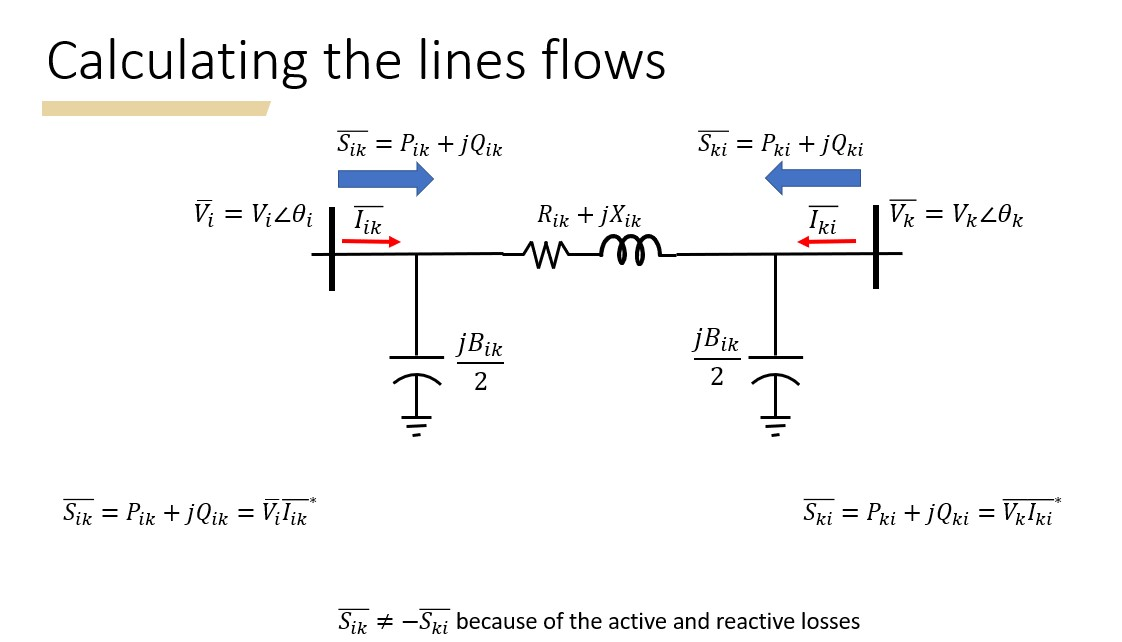

In [13]:
from IPython.display import Image
Image(filename='Materials\calculating line flows.jpg')

For power at bus i, it is positive if net generation at bus, i.e. branch is delivering power to bus or bus is withdrawing power from banch. Thus line_p_i = - P_ik.

In [14]:
## Now got P,V,Q,theta for all buses, calculate the lines flows for each snapshot
for time in snapshots_df["name"]:
    output_line_p0[time] = {}
    output_line_p1[time] = {}
    output_line_q0[time] = {}
    output_line_q1[time] = {}    
    V_time = all_V[time]
    theta_time = all_theta[time]
    P_flow,Q_flow,complex_S,complex_I, complex_V = line_flow(All_buses,V_time,theta_time,ymatrix,B)
    for index, row in lines_df.iterrows():
        i = name_to_id[row["bus0"]]
        k = name_to_id[row["bus1"]]
        output_line_p0[time][row["bus0"]] = -P_flow[i,k]
        output_line_p1[time][row["bus1"]] = -P_flow[k,i]
        output_line_q0[time][row["bus0"]] = -Q_flow[i,k]
        output_line_q1[time][row["bus1"]] = -Q_flow[k,i]


C:\Users\shiyu\AppData\Local\Temp\ipykernel_16552\1845477254.py:288: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  complex_I[i,k] = (complex_V[i] - complex_V[k]) * ymatrix[i,k] + 1j * B[i,k]/2*complex_V[i]
C:\Users\shiyu\AppData\Local\Temp\ipykernel_16552\1845477254.py:290: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  complex_S[i,k] = complex_V[i] * complex_I[i,k].conjugate()


## Model Output:

In [15]:
## Save outputs as filesw
def creat_df_for_bus(output_P):
    df = pd.DataFrame.from_dict(output_P, orient='index')
    #sort by id
    sorted_columns = sorted(df.columns, key=lambda col: name_to_id[col])
    df = df[sorted_columns]
    df.index.name = 'snapshots'
    df = df.reset_index()
    return df
def creat_df_for_line(output_line_p0,bus):
    df = pd.DataFrame.from_dict(output_line_p0, orient='index')
    if bus == "bus0":
        sorted_columns = sorted(df.columns, key=lambda col: lines_df.loc[lines_df["bus0"] == col, 'name'].values[0])
        df = df[sorted_columns]
        df.index.name = 'snapshots/lines'
        df = df.reset_index()
        id_mapping = dict(zip(lines_df["bus0"], lines_df['name']))  
        df = df.rename(columns=id_mapping) 
    if bus == "bus1":
        sorted_columns = sorted(df.columns, key=lambda col: lines_df.loc[lines_df["bus1"] == col, 'name'].values[0])
        df = df[sorted_columns]
        df.index.name = 'snapshots/lines'
        df = df.reset_index()
        id_mapping = dict(zip(lines_df["bus1"], lines_df['name']))  
        df = df.rename(columns=id_mapping) 
    return df

output_P_df = creat_df_for_bus(output_P)
output_Q_df = creat_df_for_bus(output_Q)
output_V_df = creat_df_for_bus(output_V)
output_theta_df = creat_df_for_bus(output_theta)
output_P_df.to_csv('./Model_output/buses-p.csv', index=False)
output_Q_df.to_csv('./Model_output/buses-q.csv', index=False)
output_V_df.to_csv('./Model_output/buses-v_mag.csv', index=False)
output_theta_df.to_csv('./Model_output/buses-v_ang.csv', index=False)
output_line_p0_df = creat_df_for_line(output_line_p0,"bus0")
output_line_p1_df = creat_df_for_line(output_line_p1,"bus1")
output_line_q0_df = creat_df_for_line(output_line_q0,"bus0")
output_line_q1_df = creat_df_for_line(output_line_q1,"bus1")
output_line_p0_df.to_csv('./Model_output/lines-p0.csv', index=False)
output_line_p1_df.to_csv('./Model_output/lines-p1.csv', index=False)
output_line_q0_df.to_csv('./Model_output/lines-q0.csv', index=False)
output_line_q1_df.to_csv('./Model_output/lines-q1.csv', index=False)

Please check the [model output](Model_output) here.